## Time Series Forecasting in Python

### Milestone 1 
#### Preparing the Energy and Temperture Data

In [3]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [4]:
#importing the data into dataframes
#temperture data
hr_temp = pd.read_csv("hr_temp_20170201-20200131_subset.csv")
#energy data
hrl_metered = pd.read_csv("hrl_load_metered - 20170201-20200131.csv")


In [5]:
#date is done hourly; checking for any nulls in the data
#hr_temp.head()
hr_temp.isnull().sum()

STATION                      0
DATE                         0
REPORT_TYPE                  0
SOURCE                       0
HourlyDryBulbTemperature    37
dtype: int64

In [6]:
hr_temp['DATE'] = pd.to_datetime(hr_temp['DATE'],format='%Y-%m-%d %H:%M:%S')
hr_temp.dtypes

STATION                              int64
DATE                        datetime64[ns]
REPORT_TYPE                         object
SOURCE                               int64
HourlyDryBulbTemperature           float64
dtype: object

In [7]:
hr_temp.head()

,STATION,DATE,REPORT_TYPE,SOURCE,HourlyDryBulbTemperature
0,72520514762,2017-02-01 00:53:00,FM-15,7,37.0
1,72520514762,2017-02-01 01:53:00,FM-15,7,37.0
2,72520514762,2017-02-01 02:53:00,FM-15,7,36.0
3,72520514762,2017-02-01 03:53:00,FM-15,7,36.0
4,72520514762,2017-02-01 04:53:00,FM-15,7,36.0


In [8]:
#interpolation for missing values
hr_temp['HourlyDryBulbTemperature'].interpolate(inplace=True)

#Extract all the date time information for joins & et
hr_temp['hour'] = pd.DatetimeIndex(hr_temp['DATE']).hour
hr_temp['weekday'] = pd.DatetimeIndex(hr_temp['DATE']).weekday
hr_temp['month'] = pd.DatetimeIndex(hr_temp['DATE']).month
hr_temp['year'] = pd.DatetimeIndex(hr_temp['DATE']).year
hr_temp['date4join'] = pd.to_datetime(hr_temp['DATE']).dt.date

In [9]:
hr_temp.isnull().sum()

STATION                     0
DATE                        0
REPORT_TYPE                 0
SOURCE                      0
HourlyDryBulbTemperature    0
hour                        0
weekday                     0
month                       0
year                        0
date4join                   0
dtype: int64

In [10]:
#date is done hourly; checking for any nulls in the data

hrl_metered.head()

hrl_metered.isnull().sum()

datetime_beginning_utc    0
datetime_beginning_ept    0
nerc_region               0
mkt_region                0
zone                      0
load_area                 0
mw                        0
is_verified               0
dtype: int64

In [11]:
#use datetime_beginning_ept for date
hrl_metered['DATE'] = pd.to_datetime(hrl_metered['datetime_beginning_ept'],format='%m/%d/%Y %H:%M')
hrl_metered['date4join'] = pd.to_datetime(hrl_metered['DATE']).dt.date
hrl_metered['hour'] = pd.DatetimeIndex(hrl_metered['DATE']).hour
hrl_metered.head()

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified,DATE,date4join,hour
0,2/1/2017 5:00,2/1/2017 0:00,RFC,WEST,DUQ,DUQ,1419.881,True,2017-02-01 00:00:00,2017-02-01,0
1,2/1/2017 6:00,2/1/2017 1:00,RFC,WEST,DUQ,DUQ,1379.505,True,2017-02-01 01:00:00,2017-02-01,1
2,2/1/2017 7:00,2/1/2017 2:00,RFC,WEST,DUQ,DUQ,1366.106,True,2017-02-01 02:00:00,2017-02-01,2
3,2/1/2017 8:00,2/1/2017 3:00,RFC,WEST,DUQ,DUQ,1364.453,True,2017-02-01 03:00:00,2017-02-01,3
4,2/1/2017 9:00,2/1/2017 4:00,RFC,WEST,DUQ,DUQ,1391.265,True,2017-02-01 04:00:00,2017-02-01,4


In [12]:
energy_data = hrl_metered[['date4join','hour','mw']]

In [13]:
#Create dataframe for the combined energy and temperture data 
temp_energy = hr_temp.merge(energy_data,how='left',on=['date4join','hour'])
temp_energy.rename(columns={'DATE':'date','HourlyDryBulbTemperature':'temp'},inplace=True)
temp_energy.head()

,STATION,date,REPORT_TYPE,SOURCE,temp,hour,weekday,month,year,date4join,mw
0,72520514762,2017-02-01 00:53:00,FM-15,7,37.0,0,2,2,2017,2017-02-01,1419.881
1,72520514762,2017-02-01 01:53:00,FM-15,7,37.0,1,2,2,2017,2017-02-01,1379.505
2,72520514762,2017-02-01 02:53:00,FM-15,7,36.0,2,2,2,2017,2017-02-01,1366.106
3,72520514762,2017-02-01 03:53:00,FM-15,7,36.0,3,2,2,2017,2017-02-01,1364.453
4,72520514762,2017-02-01 04:53:00,FM-15,7,36.0,4,2,2,2017,2017-02-01,1391.265


In [14]:
#dropping extra columns and setting the date as the index
temp_energy.drop(columns=['STATION','REPORT_TYPE','SOURCE','date4join'],inplace=True)
temp_energy = temp_energy[['date','mw','temp','hour','weekday','month','year']]
temp_energy.set_index('date',inplace=True)
temp_energy.head()

,mw,temp,hour,weekday,month,year
date,,,,,,
2017-02-01 00:53:00,1419.881,37.0,0,2,2,2017
2017-02-01 01:53:00,1379.505,37.0,1,2,2,2017
2017-02-01 02:53:00,1366.106,36.0,2,2,2,2017
2017-02-01 03:53:00,1364.453,36.0,3,2,2,2017
2017-02-01 04:53:00,1391.265,36.0,4,2,2,2017


In [15]:
"""
Subsetting the data into test & train based on the following:
    - Use all of the data up through 12-31-2019 for training
    - January 2020 as your testing datasets.

Note to self:
test = temp_energy.loc[temp_energy['date'] >= '2020-01-01']  - if date is not indexed
Good references for task 4:
https://statisticsglobe.com/set-datetimeindex-pandas-dataframe-python
https://stackoverflow.com/questions/44547401/pandas-selecting-dataframe-rows-between-two-dates-datetime-index
"""

training = temp_energy[(temp_energy.index.get_level_values(0) < '2020-01-01 00:00:00')]

training.head()

,mw,temp,hour,weekday,month,year
date,,,,,,
2017-02-01 00:53:00,1419.881,37.0,0,2,2,2017
2017-02-01 01:53:00,1379.505,37.0,1,2,2,2017
2017-02-01 02:53:00,1366.106,36.0,2,2,2,2017
2017-02-01 03:53:00,1364.453,36.0,3,2,2,2017
2017-02-01 04:53:00,1391.265,36.0,4,2,2,2017


In [16]:


test = temp_energy[(temp_energy.index.get_level_values(0) >= '2020-01-01 00:00:00')]
test.head()

,mw,temp,hour,weekday,month,year
date,,,,,,
2020-01-01 00:53:00,1363.428,31.0,0,2,1,2020
2020-01-01 01:53:00,1335.975,29.0,1,2,1,2020
2020-01-01 02:53:00,1296.817,30.0,2,2,1,2020
2020-01-01 03:53:00,1288.403,30.0,3,2,1,2020
2020-01-01 04:53:00,1292.263,31.0,4,2,1,2020


### Milestone 2
#### Exploring/Visualizing Energy and Temperture Data
Objective:
Visualize the energy data you are going to model and explore the relationship between the energy data and corresponding temperature data. We will use the takeaways from these explorations to build our first model in the next section.

<Axes: xlabel='date', ylabel='Energy'>

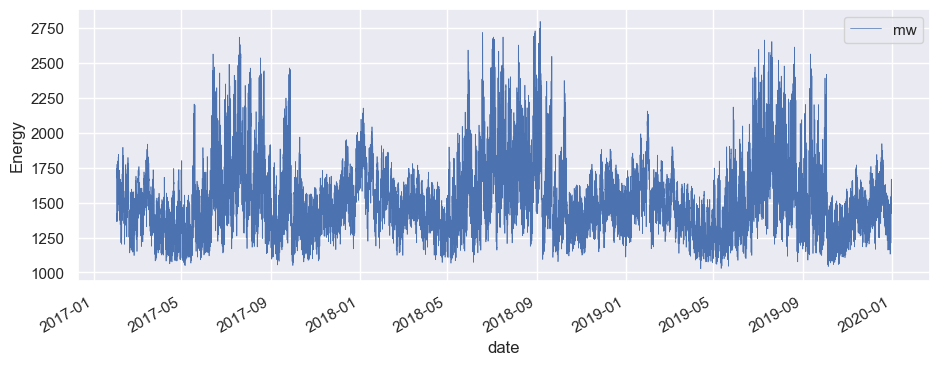

In [18]:
"""
Plotting the training energy data over time
Note to self:
Initally was going to seabourne but it had errors using the index values. Usingmatplotlib instead. See
https://github.com/mwaskom/seaborn/issues/2515
#sns.lineplot(x=training.index, y='mw',data=training)  
#This is a good tutorial as reccomended by the instructor:
https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
Using seaborn styling
The generic overall pattern from the plot below is that peak energy consumption is between June and August (summer months in). 
The lower energy usage is in the spring(April-June) and fall seasons(Sept - Nov)
"""
sns.set(rc={'figure.figsize':(11,4)})
training.plot(y='mw',ylabel= "Energy",linewidth=0.5)

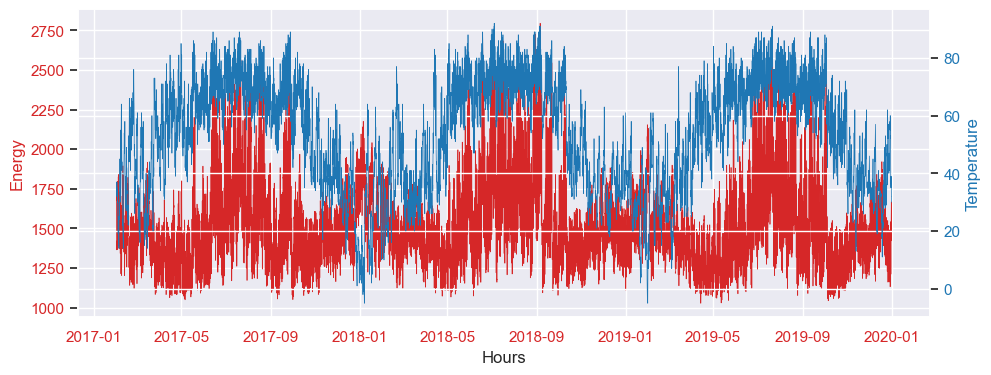

In [19]:
#Overlaying the overall energy and temperture data

fig, ax = plt.subplots()
ax2 = ax.twinx() #instantiate a second Axes that shares the same x-axis

color1 = 'tab:red'
ax.plot(training['mw'],linewidth=0.5,label='Energy',color=color1)
ax.set_xlabel('Hours')
ax.set_ylabel('Energy',color=color1)
ax.tick_params(labelcolor=color1)

color2 = 'tab:blue'
ax2.plot(training['temp'],linewidth=0.5,label='Temperature',color=color2)
ax2.set_ylabel('Temperature',color=color2)
ax2.tick_params(labelcolor=color2)

<Axes: xlabel='date', ylabel='Energy'>

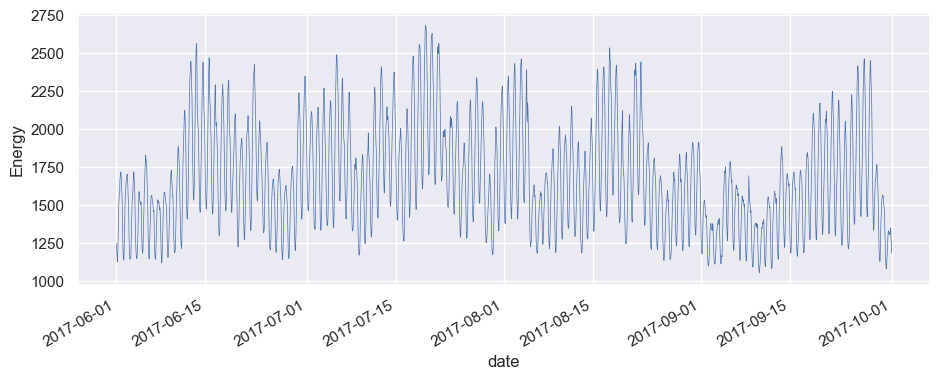

In [20]:
#Looking at months June - September
training['mw'].loc['2017-06':'2017-09'].plot(ylabel= "Energy",linewidth=0.5)

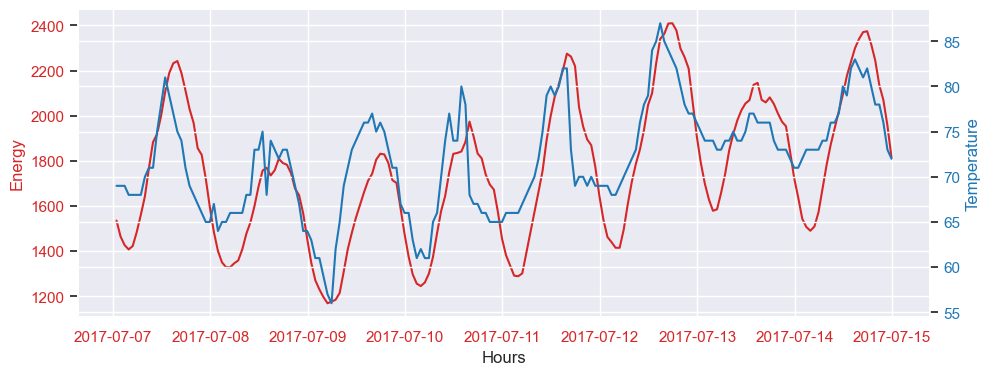

In [21]:
#Plotting one week July 7 - June 14 2017
#Overlaying energy and temperature 
#Energy and Temperture peaks appear to have a xorrelated relationship
sStart,sEnd = '2017-07-07','2017-07-14'
#training['mw'].loc['2017-07-07':'2017-07-14'].plot(linewidth=0.5,ylabel="Energy",marker='o',linestyle='-')

fig, ax = plt.subplots()
ax2 = ax.twinx() #instantiate a second Axes that shares the same x-axis

color1 = 'tab:red'
ax.plot(training.loc[sStart:sEnd,'mw'],linestyle='-',label='Energy',color=color1)
ax.set_xlabel('Hours')
ax.set_ylabel('Energy',color=color1)
ax.tick_params(labelcolor=color1)

color2 = 'tab:blue'
ax2.plot(training.loc[sStart:sEnd,'temp'],linestyle='-',label='Temperature',color=color2)
ax2.set_ylabel('Temperature',color=color2)
ax2.tick_params(labelcolor=color2)

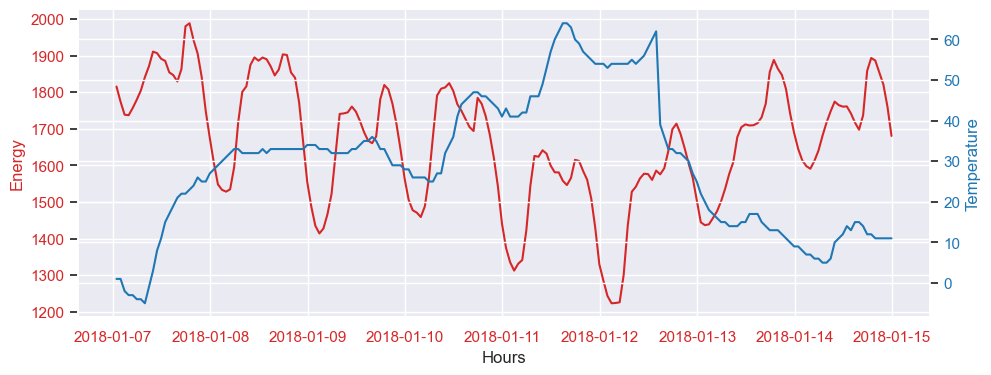

In [38]:
#Plotting one week Jan 7 - Jan 14 2017
#Overlaying energy and temperature 
#For the winter month snapshot, energy and temperture do not appear to have 
#a correlated relationship 
wStart,wEnd = '2018-01-07','2018-01-14'


fig, ax = plt.subplots()
ax2 = ax.twinx() #instantiate a second Axes that shares the same x-axis

color1 = 'tab:red'
ax.plot(training.loc[wStart:wEnd,'mw'],linestyle='-',label='Energy',color=color1)
ax.set_xlabel('Hours')
ax.set_ylabel('Energy',color=color1)
ax.tick_params(labelcolor=color1)

color2 = 'tab:blue'
ax2.plot(training.loc[wStart:wEnd,'temp'],linestyle='-',label='Temperature',color=color2)
ax2.set_ylabel('Temperature',color=color2)
ax2.tick_params(labelcolor=color2)

<Axes: xlabel='date', ylabel='Energy'>

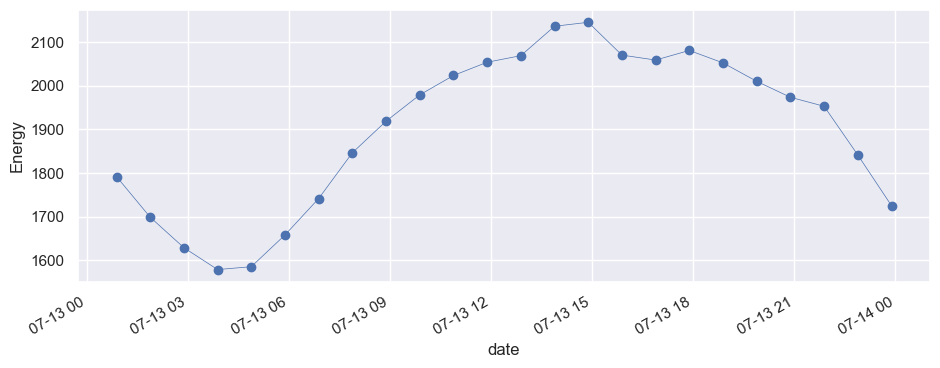

In [23]:
#Consider one day with energy only
training['mw'].loc['2017-07-13'].plot(linewidth=0.5,ylabel= "Energy",marker='o',linestyle='-')

<Axes: xlabel='date', ylabel='Temperture'>

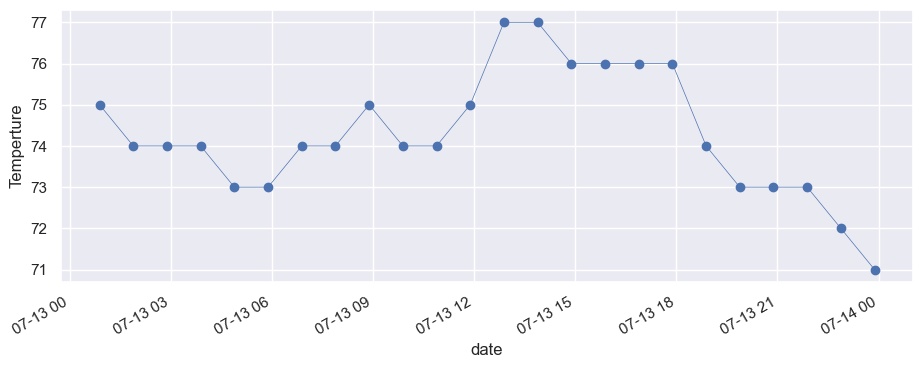

In [24]:
#Adding temp only
training['temp'].loc['2017-07-13'].plot(linewidth=0.5,ylabel="Temperture",marker='o',linestyle='-')

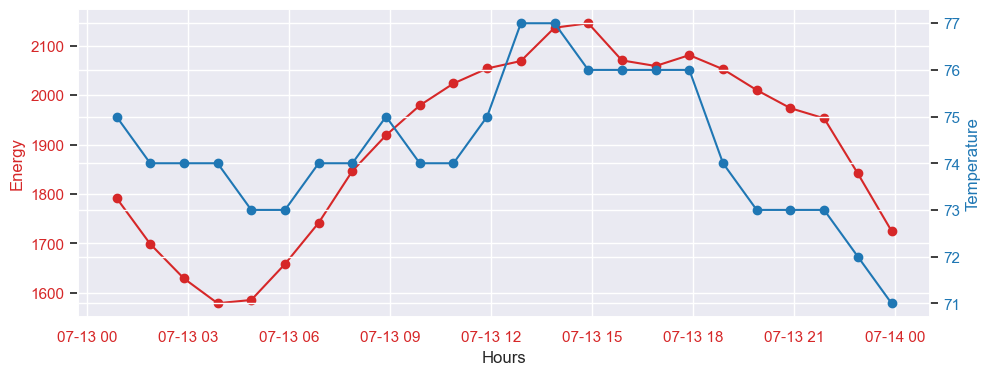

In [25]:
#tempeture and energy overlay using twinx
#One day
fig, ax = plt.subplots()
ax2 = ax.twinx() #instantiate a second Axes that shares the same x-axis

color1 = 'tab:red'
ax.plot(training.loc['2017-07-13','mw'],marker='o',linestyle='-',label='Energy(mw)',color=color1)
ax.set_xlabel('Hours')
ax.set_ylabel('Energy',color=color1)
ax.tick_params(labelcolor=color1)

color2 = 'tab:blue'
ax2.plot(training.loc['2017-07-13','temp'],marker='o',linestyle='-',label='Temperature(F)',color=color2)
ax2.set_ylabel('Temperature',color=color2)
ax2.tick_params(labelcolor=color2)
#ax.legend()


In [42]:
"""
#Calculate the correlation 
#Using Pearson
Note: Pearson (product-moment) correlation coefficient is a measure of the linear relationship between two features.
Pearson value is low (less than .5) which suggests the relationship between energy and temperture is positive and a weak correlation  

"""
pcorrelation = training['mw'].corr(training['temp'])
scorrelation = training['mw'].corr(training['temp'],method='spearman')
kcorrelation = training['mw'].corr(training['temp'],method='kendall')

print("The Pearson correlation between energy and temperture is: ",pcorrelation)
print("The Spearman rho between energy and temperture is: ",scorrelation)
print("The Kendall tau between energy and temperture is: ",kcorrelation)

The Pearson correlation between energy and temperture is:  0.32302557766674944
The Spearman rho between energy and temperture is:  0.30806173310723023
The Kendall tau between energy and temperture is:  0.2059411991197771


Text(0.5, 1.0, 'Energy and Temp Scatter')

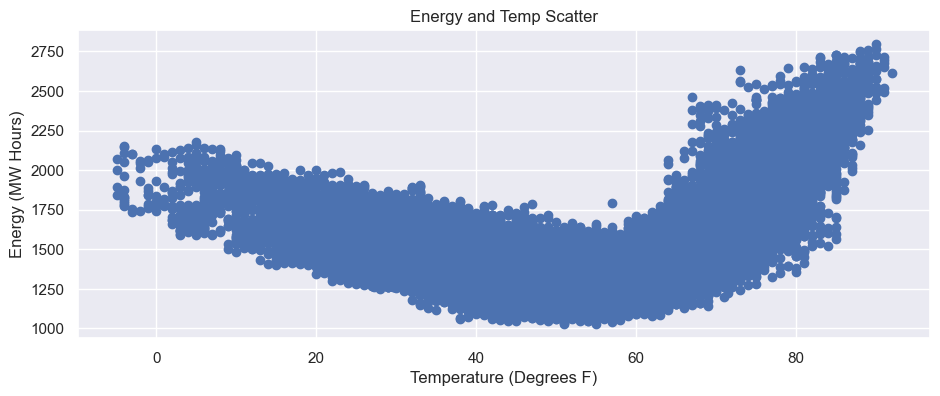

In [35]:
#Scatter Plot
plt.scatter(x='temp',y='mw',data=training)
plt.xlabel("Temperature (Degrees F)")
plt.ylabel("Energy (MW Hours)")
plt.title("Energy and Temp Scatter")